# Import packages

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split,RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap
from scipy.stats import ttest_ind


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/playground-series-s5e5/sample_submission.csv
/kaggle/input/playground-series-s5e5/train.csv
/kaggle/input/playground-series-s5e5/test.csv


# Data Overview - training and testing data

I presented the shape of the datasets, the list of columns, and the descriptive statistics for both the training and testing sets. Based on the summary results:

* There are no missing values in either dataset.

* Several features exhibit outliers, particularly in the columns: Age, Height, Weight, Duration, Heart_Rate, and Body_Temp.

In [3]:
train = pd.read_csv("/kaggle/input/playground-series-s5e5/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e5/test.csv")

def check_data(data, name='DataFrame'):
    print(f'{name}:')
    print(f'\nData shape: {data.shape}')
    print(f'\nColumns: {list(data.columns)}')
    print(f'\nDescriptive statistics: {data.describe()}\n')
    #print(f'\nNumber of missing value for each column:\n')
    #print(data.isnull().sum())


check_data(train, 'Training data')
check_data(test, 'Testing data')

    

Training data:

Data shape: (750000, 9)

Columns: ['id', 'Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Calories']

Descriptive statistics:                   id            Age         Height         Weight  \
count  750000.000000  750000.000000  750000.000000  750000.000000   
mean   374999.500000      41.420404     174.697685      75.145668   
std    216506.495284      15.175049      12.824496      13.982704   
min         0.000000      20.000000     126.000000      36.000000   
25%    187499.750000      28.000000     164.000000      63.000000   
50%    374999.500000      40.000000     174.000000      74.000000   
75%    562499.250000      52.000000     185.000000      87.000000   
max    749999.000000      79.000000     222.000000     132.000000   

            Duration     Heart_Rate      Body_Temp       Calories  
count  750000.000000  750000.000000  750000.000000  750000.000000  
mean       15.421015      95.483995      40.036253      88.282781  
std    

We further examined the percentage of outliers in each variable in training data. The analysis shows that body_temp has the highest proportion of outliers at 3.64%. All other features—including Calories, Heart_Rate, Height, Weight, Age, and Duration—have outlier rates below 1%.

**This suggests that, at this stage, outliers may not pose a significant issue and can likely be handled through standard scaling or left as-is.**

In [6]:
#outliers analysis

features = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Calories']

def outliers(col):
    Q1 = train[col].quantile(0.25)
    Q3 = train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.25 * IQR
    upper_bound = Q3 + 1.25 * IQR
    outliers = train[(train[col] < lower_bound) | (train[col] > upper_bound)].shape[0]
    outliers_p = (outliers/train.shape[0])*100
    return outliers_p

outliers_df = pd.DataFrame({
    'Feature':features,
    'Outlier %':[outliers(col) for col in features]    
})

print('The percentage of outliers in each variable in training data')
print(outliers_df.sort_values(by = 'Outlier %', ascending = False))

The percentage of outliers in each variable in training data
      Feature  Outlier %
5   Body_Temp   3.639867
6    Calories   0.183333
4  Heart_Rate   0.077867
1      Height   0.024533
2      Weight   0.013867
0         Age   0.000000
3    Duration   0.000000


# Exploratory Analysis: Distribution of Dependent and Independent Variables

Calories is the dependent variable in this project, I noticed that most people burn low calories, but a few burn a lot, that is why the distribution of calories is right-skewed. RMSLE (Root Mean Squared Log Error) was used as a metric in this project, which already accounts for skew, so no need to log calories even though it's right-skewed distribution.

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


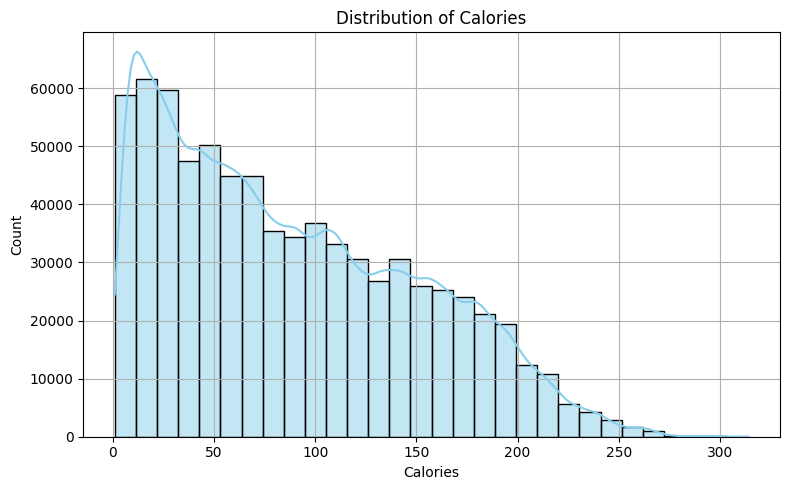

Skewness: 0.54


In [7]:
#target variable (right-skewed, RMSLE already accounts for skew, no need to log calories)
plt.figure(figsize = (8, 5))
sns.histplot(data =train, x = 'Calories', bins = 30, kde = True, stat = 'count', color = 'skyblue')
plt.xlabel('Calories')
plt.ylabel('Count')
plt.title('Distribution of Calories')
plt.grid(True)
plt.tight_layout()
plt.show()
print("Skewness:",round(train['Calories'].skew(),2))
#print("Most people burn low calories, but a few burn a lot (long right tail)")

From an exploratory data analysis (EDA) perspective, the distributions of the training and testing datasets appear largely consistent across all variables, indicating that the data split is representative and should support good model generalization. For Age, both datasets show a right-skewed distribution, with most individuals clustered between 20 and 40 years old, and fewer older participants, suggesting age-related patterns can be learned consistently. Height is roughly normally distributed in both sets, centered around 170–180 cm, with only slight differences in density peaks. Weight also shows a slightly right-skewed pattern, concentrated mostly between 55 and 90 kg; although the testing set shows a slightly stronger peak around 65–75 kg, the overall shapes are similar.

Duration exhibits a nearly uniform distribution across 0 to 30 minutes in both training and testing data, implying a broad range of exercise or test times that can support robust modeling. Heart rate follows a normal distribution, centered around 90–100 bpm, and is highly consistent between the two sets, suggesting no significant sampling bias for this physiological measure. Body temperature has a right-skewed distribution, with most values concentrated between 39.5 and 41 °C. While the testing set appears slightly more peaked around 40 °C, the overall shape aligns well with the training data.

These distributional similarities suggest that no major shifts or data leakage exist, and no immediate re-sampling is required. From a feature engineering standpoint, normalization or standardization would be appropriate for variables like height, weight, and heart rate, given their approximate normality. In contrast, age and body temperature may benefit from transformations (such as log or Box-Cox) to address skewness. Age could also potentially be grouped into bins if nonlinear effects are expected.

Overall, the EDA findings provide confidence that the model can learn patterns consistently across both datasets. These insights lay a strong foundation for thoughtful feature engineering steps that will enhance model performance and interpretability in the next stage of analysis.

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


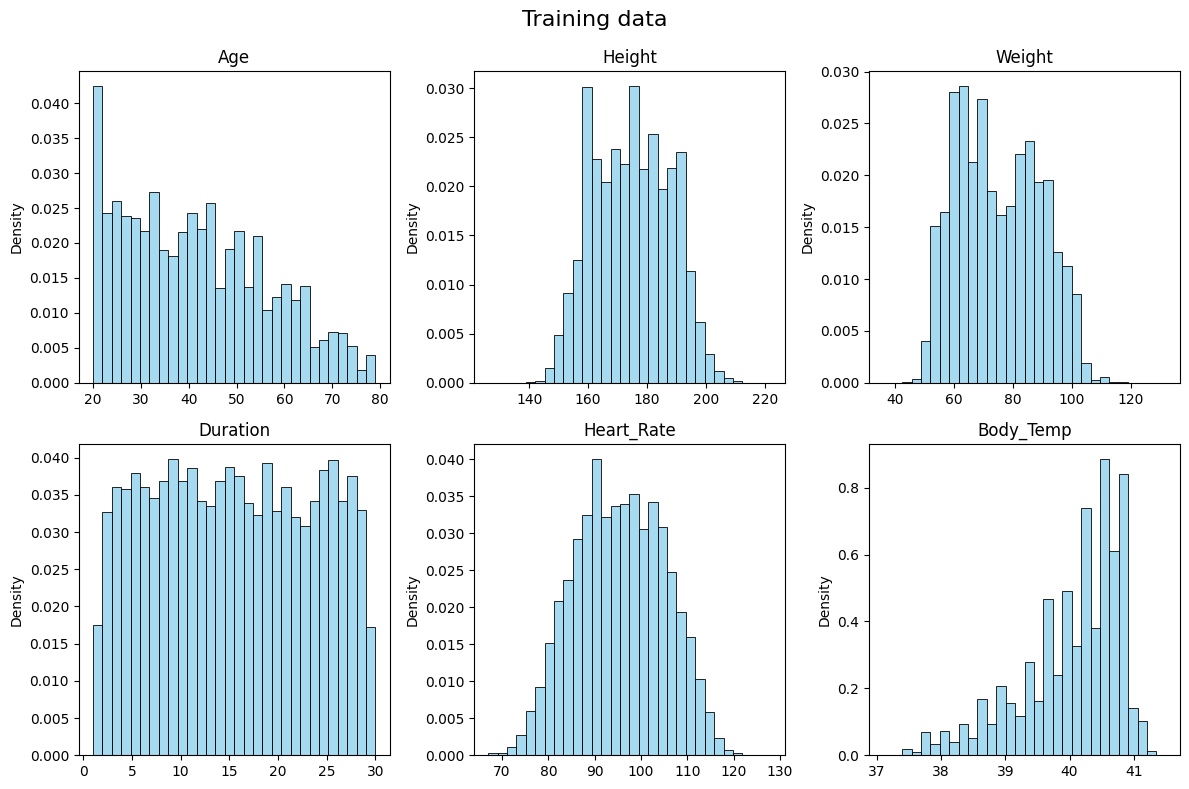

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


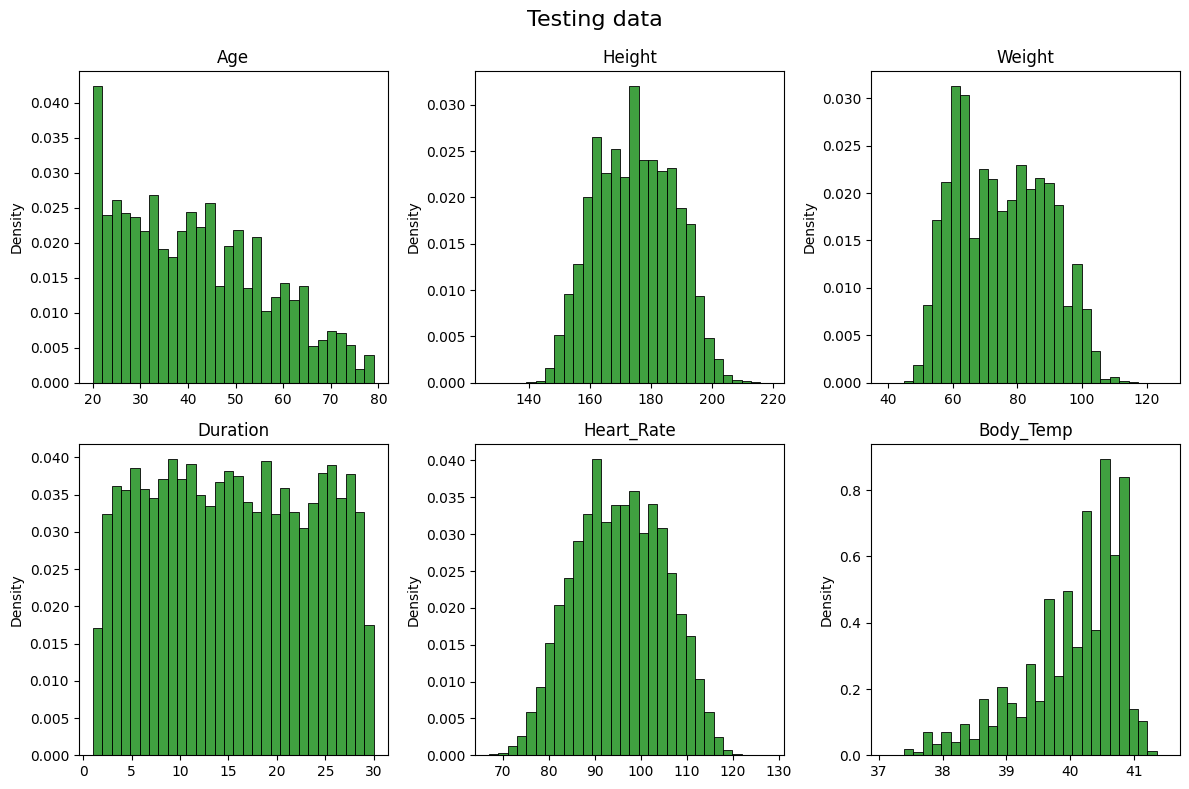

In [9]:
#Distribution for each variable (train vs test)
#list(train.columns)

def histogram_data(data, data_name = 'default', color = 'skyblue'):
    cols_to_plot = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
    
    # Grid size
    n_cols = 3
    n_rows = -(-len(cols_to_plot) // n_cols)  # ceiling division
    
    # Set up the figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))
    axes = axes.flatten()
    
    
    # Loop through each column and plot
    for i, col in enumerate(cols_to_plot):
        sns.histplot(data[col], ax=axes[i], bins=30, kde=False, color=color, stat='density')
        axes[i].set_title(f'{col}')
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Density')
    
    # Turn off unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    fig.suptitle(data_name, fontsize=16)
    plt.show()

histogram_data(train, 'Training data')

histogram_data(test, 'Testing data', 'green')



use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN be

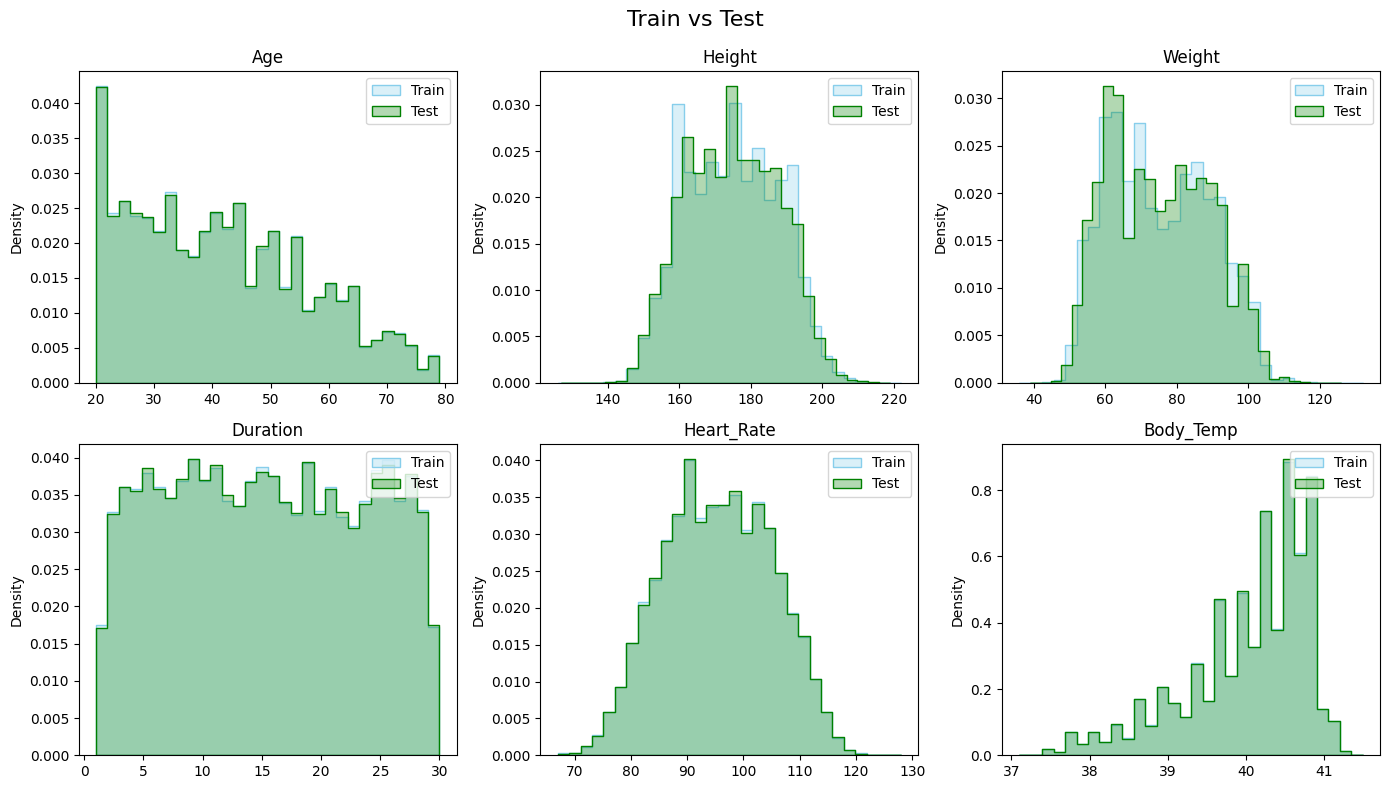

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def histogram_compare(train, test, data_name='Train vs Test'):
    cols_to_plot = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
    
    # Grid size
    n_cols = 3
    n_rows = -(-len(cols_to_plot) // n_cols)  # ceiling division
    
    # Set up the figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 8))
    axes = axes.flatten()

    for i, col in enumerate(cols_to_plot):
        sns.histplot(train[col], ax=axes[i], bins=30, kde=False, stat='density', 
                     color='skyblue', label='Train', element='step', fill=True, alpha=0.3)
        sns.histplot(test[col], ax=axes[i], bins=30, kde=False, stat='density', 
                     color='green', label='Test', element='step', fill=True, alpha=0.3)

        axes[i].set_title(f'{col}')
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Density')
        axes[i].legend()

    # Turn off unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    fig.suptitle(data_name, fontsize=16)
    plt.show()

# Call the new function
histogram_compare(train, test)


# Exploratory Analysis: Pearson Correlation coefficient

Before diving into data engineering, I conducted a Pearson correlation analysis to explore linear relationships between Calories and the independent variables. The results revealed that Duration, BodyTemperature, and HeartRate exhibit relatively strong positive correlations with Calories.

**This suggests that these variables may carry significant predictive power and should be prioritized during feature engineering and model development phases.**

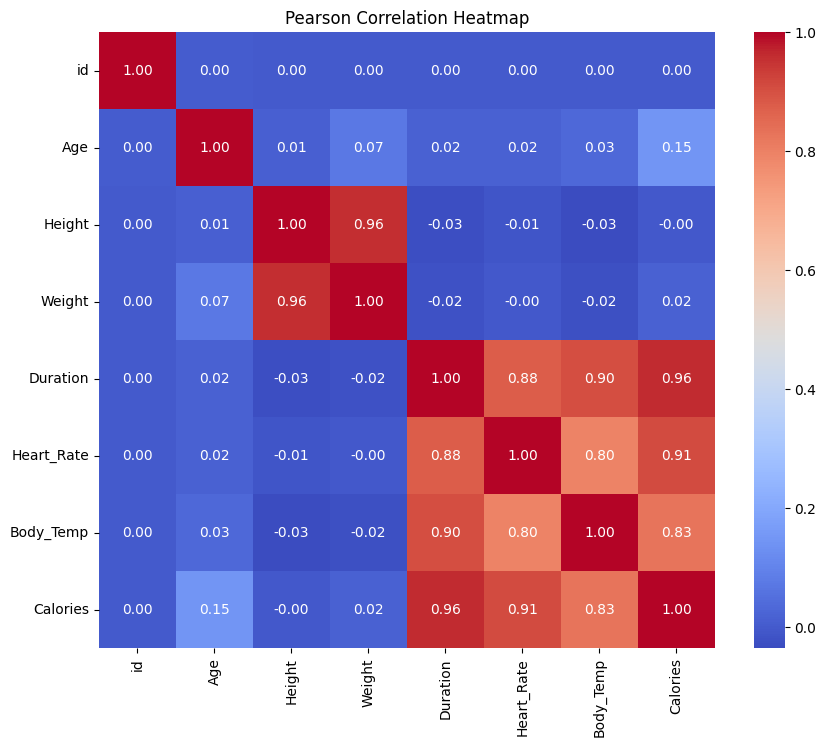

In [18]:
#find relationships between x and y (pearson correlation coefficient)
#High correlation wtih calories: duration, body temp, Heart rate
train_corr = train.drop('Sex', axis = 1)
corr = train_corr.corr(method = 'pearson')
plt.figure(figsize = (10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Pearson Correlation Heatmap')
plt.show()

# Categorical Feature Exploration: Sex and Calorie Distribution

Since Sex is a categorical variable, it is not suitable for Pearson correlation analysis, which requires continuous and normally distributed variables. To explore its relationship with Calories, I created a box plot to visualize the distribution of calorie expenditure across sexes.

The plot shows that males and females exhibit similar calorie distributions, with comparable medians and interquartile ranges. A few outliers are present in both groups, but overall, the variation appears consistent.

Although the direct influence of Sex on Calories may be limited, it can still offer indirect predictive value. For example, Sex can be incorporated into interaction terms with continuous variables (e.g., HeartRate × Sex) to capture subtle, group-specific patterns in calories expenditure.

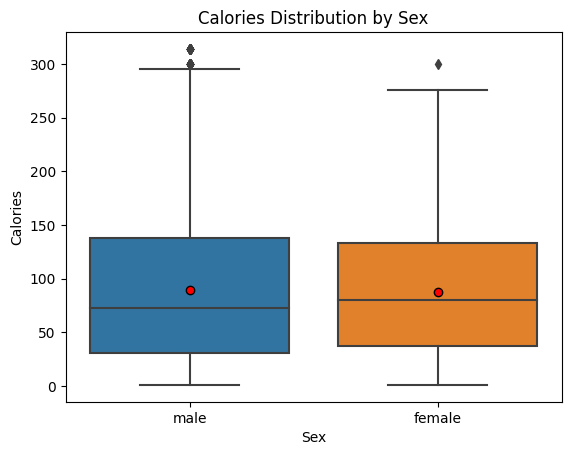

In [29]:
sns.boxplot(x='Sex', y='Calories', data=train, showmeans=True,
            meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "black"})
plt.title('Calories Distribution by Sex')
plt.show()




# Assessment of Multicollinearity Using Variance Inflation Factor (VIF)

In this analysis, Variance Inflation Factor (VIF) was calculated to assess multicollinearity among the continuous predictors: Age, Height, Weight, Duration, Heart_Rate, and Body_Temp. VIF measures how much the variance of a regression coefficient is inflated due to collinearity with other predictors — a value above 10 is often considered indicative of serious multicollinearity issues. In these results, Weight and Height show high VIF values (around 12.77 and 12.70, respectively), suggesting they are strongly correlated with other features in the dataset. Duration and Body_Temp also show moderately elevated VIF values (8.51 and 5.43), while Heart_Rate has a moderate value (4.29), and Age shows a low VIF (1.05), indicating minimal collinearity.

Multicollinearity is particularly problematic for linear models, such as linear or logistic regression, because it can make coefficient estimates unstable and inflate standard errors, reducing interpretability. In contrast, tree-based models (e.g., decision trees, random forests, gradient boosting) are generally robust to multicollinearity because they split variables sequentially and do not rely on coefficient estimation in the same way. Therefore, while these VIF results highlight potential collinearity concerns that should be addressed (e.g., through feature selection, dimensionality reduction, or careful interpretation) when using linear models, they are less critical if the plan is to use tree-based approaches.

Overall, these findings suggest that attention may be needed if you intend to use linear methods, particularly regarding Height and Weight, which might either be combined or one excluded depending on domain relevance and interpretability needs.

In [42]:
#should collinearirt be considered in linear model only? how about tree-based model?
#examine collinearirty between variables, VIF
features = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
X = train[features]
X = X.assign(Intercept=1)

#calculate VIF
vif_df = pd.DataFrame()
vif_df['Variable'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_df = vif_df[vif_df['Variable'] != 'Intercept'].sort_values(by='VIF', ascending = False)
print(vif_df)

     Variable        VIF
2      Weight  12.766902
1      Height  12.702162
3    Duration   8.510592
5   Body_Temp   5.434871
4  Heart_Rate   4.285830
0         Age   1.050873


# Feature engineering

Feature engineering is a crucial step in machine learning pipelines because it allows us to transform raw data into more informative and meaningful representations that improve model performance and interpretability. In this step, we focus on creating new derived features that capture important relationships and domain knowledge rather than simply analyzing existing distributions.

First, categorical variables such as Sex are converted into numerical format using one-hot encoding to ensure compatibility with machine learning algorithms. We then introduce a new feature, estimated calories (e_Calories), derived using different formulas for males and females based on Age, Weight, Heart Rate, and Duration. This new feature integrates domain-specific physiological insights and provides an interpretable estimate that can help the model better understand calorie expenditure.

In addition, we calculate BMI (Body Mass Index) as a ratio of Weight and squared Height, a common health-related indicator often associated with energy expenditure and fitness level. To further capture complex interactions and nonlinear relationships, we create several interaction terms such as HeartRate × Duration, Weight × Duration, and BodyTemp × HeartRate, as well as polynomial terms like squared Duration and squared HeartRate. Finally, we also transform Calories using a logarithmic scale (log1p) to reduce skewness and stabilize variance, making it easier for the model to learn.

These new engineered features enable the model to better capture underlying physiological patterns, improve predictive power, and potentially reveal subtle effects that raw features alone might miss. Overall, this approach enriches the dataset and sets a solid foundation for building robust and interpretable models.

In [5]:

#train['Sex'] = train['Sex'].map({'male':1, 'female':0})
train = pd.get_dummies(train, drop_first=True)
test = pd.get_dummies(test, drop_first=True)

#estimated calories
train["e_Calories"] = np.where(
    train["Sex_male"] == 1,
    ((train['Age'] * 0.2017) - 
     (train['Weight'] * 0.09036) + 
     (train['Heart_Rate'] * 0.6309) - 55.0969) * train['Duration'] / 4.184,
    ((train['Age'] * 0.074) - 
     (train['Weight'] * 0.05741) + 
     (train['Heart_Rate'] * 0.4472) - 20.4022) * train['Duration'] / 4.184
    
)

test['e_Calories'] = np.where(
    test['Sex_male'] == 1,
    ((test['Age'] * 0.2017) - 
     (test['Weight'] * 0.09036) + 
     (test['Heart_Rate'] * 0.6309) - 55.0969) * test['Duration'] / 4.184,
    ((test['Age'] * 0.074) - 
     (test['Weight'] * 0.05741) + 
     (test['Heart_Rate'] * 0.4472) - 20.4022) * test['Duration'] / 4.184
)

train['BMI'] = train['Weight'] / ((train['Height'] / 100) ** 2)
test['BMI'] = test['Weight'] / ((test['Height'] / 100) ** 2)

#train['Difference'] = train['Calories'] - train['e_Calories']
#test['Difference'] = test['Calories'] - test['e_Calories']


train['HeartRate_Duration'] = train['Heart_Rate'] * train['Duration']
train['Weight_Duration'] = train['Weight'] * train['Duration']
train['Temp_HeartRate'] = train['Body_Temp'] * train['Heart_Rate']

train['Duration_squared'] = train['Duration'] ** 2
train['HeartRate_squared'] = train['Heart_Rate'] ** 2

train['log_Calories'] = np.log1p(train['Calories'])

# Interaction terms
test['HeartRate_Duration'] = test['Heart_Rate'] * test['Duration']
test['Weight_Duration'] = test['Weight'] * test['Duration']
test['Temp_HeartRate'] = test['Body_Temp'] * test['Heart_Rate']

# Polynomial (squared) terms
test['Duration_squared'] = test['Duration'] ** 2
test['HeartRate_squared'] = test['Heart_Rate'] ** 2


#men:Calories = ((Age * 0.2017) - (Weight * 0.09036) + (HeartRate * 0.6309) - 55.0969) * Duration / 4.184
#women:Calories = ((Age * 0.074) - (Weight * 0.05741) + (HeartRate * 0.4472) - 20.4022) * Duration / 4.184

train.head()

,id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Sex_male,e_Calories,BMI,HeartRate_Duration,Weight_Duration,Temp_HeartRate,Duration_squared,HeartRate_squared,log_Calories
0,0,36,189.0,82.0,26.0,101.0,41.0,150.0,True,52.669140,22.955684,2626.0,2132.0,4141.0,676.0,10201.0,5.017280
1,1,64,163.0,60.0,8.0,85.0,39.7,34.0,False,36.139962,22.582709,680.0,480.0,3374.5,64.0,7225.0,3.555348
2,2,51,161.0,64.0,7.0,84.0,39.8,29.0,False,28.880621,24.690405,588.0,448.0,3343.2,49.0,7056.0,3.401197
3,3,20,192.0,90.0,25.0,105.0,40.7,140.0,True,42.119981,24.414062,2625.0,2250.0,4273.5,625.0,11025.0,4.948760
4,4,38,166.0,61.0,25.0,102.0,40.6,146.0,False,146.523602,22.136740,2550.0,1525.0,4141.2,625.0,10404.0,4.990433


# Key insights

In [1]:
#key insight###

